In [219]:
import pandas as pd
import pandas_datareader as dr
import numpy as np 
import yfinance as yf
from analysis.data.utils_analysis import create_full_dataset
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
data_tab = pd.read_html(snp500url)

tickers = data_tab[0][1:]['Symbol'].tolist()
# from analysis.data.utils_analysis import create_full_dataset
# ESG = pd.read_csv(r"C:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\analysis\datasets\1\ESG_data.csv")
# # tickers = list(ESG['ticker'].unique())
print("Total number of tickers", len(tickers))

raw = yf.download(tickers, start="2016-01-01", end="2023-01-01", auto_adjust=True)

[                       0%                       ]

Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

8 Failed downloads:
['VLTO', 'GEV', 'SW', 'SOLV', 'KVUE']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2016-01-01 -> 2023-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1451624400, endDate = 1672549200")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['CTAS', 'BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2016-01-01 -> 2023-01-01)')


In [220]:
import json
location = r"C:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\analysis\datasets\esg_data.json"

with open(location, "r") as file:
    esg_data = json.load(file)  # Parse JSON into a Python dictionary or list

rows = []
for entry in esg_data:
    ticker = entry['ticker']
    esgScores = entry.get('esgScores')
    if esgScores:
        rows.append({
            'ticker': ticker,
            'totalEsg': esgScores.get('totalEsg'),
            'environmentScore': esgScores.get('environmentScore'),
            'socialScore': esgScores.get('socialScore'),
            'governanceScore': esgScores.get('governanceScore')
        })
    else:
        rows.append({
            'ticker': ticker,
            'totalEsg': None,
            'environmentScore': None,
            'socialScore': None,
            'governanceScore': None
        })
# Create DataFrame
esg_df = pd.DataFrame(rows)

esg_df

,ticker,totalEsg,environmentScore,socialScore,governanceScore
0,AOS,26.82,6.65,13.55,6.61
1,ABT,22.21,1.81,13.84,6.56
2,ABBV,26.10,1.78,15.70,8.62
3,ACN,11.09,0.14,6.94,4.01
4,ADBE,14.06,1.69,7.23,5.14
...,...,...,...,...,...
497,XYL,22.86,10.49,8.01,4.36
498,YUM,20.51,7.04,10.25,3.22
499,ZBRA,9.94,1.79,3.34,4.81
500,ZBH,26.19,4.89,13.99,7.31


In [224]:
dataset = pd.DataFrame(raw)
missing_frac = dataset.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.2].index))
dataset.drop(columns=drop_list, axis = 1, inplace=True)
dataset.bfill(axis='index', inplace=True)
print('Null values:', dataset.isnull().values.any())
print('NaN values:', dataset.isna().values.any())



Null values: False
NaN values: False


In [225]:
import quantstats as qs

def data_vertical(data):
    dataset_vertical = data.stack(level=1).reset_index()
    dataset_vertical.rename(columns={'level_1': 'Ticker'}, inplace=True)
    dataset_vertical['Date'] = pd.to_datetime(dataset_vertical['Date']) 
    dataset_vertical.set_index('Date', inplace=True)
    return dataset_vertical
    


def feature_engineering(data):
    #avg returns
    returns = data["Close"].pct_change().mean()*252
    returns = pd.DataFrame(returns)
    final_dataframe = returns.reset_index()
    final_dataframe = final_dataframe.rename(columns={final_dataframe.columns[1]:"Yavg_return"})
    #volatility
    final_dataframe["Yavg_volatility"] = np.array(data["Close"].pct_change().std()*np.sqrt(252))

    dataset_vertical = data_vertical(data)
    dataset_vertical["daily_span"] = dataset_vertical["High"]- dataset_vertical["Low"]
    #daily_span
    final_dataframe["Davg_span"] = np.array(dataset_vertical.groupby("Ticker")["daily_span"].mean())
    #traded volume
    final_dataframe["Davg_volume"] = np.array(dataset_vertical.groupby("Ticker")["Volume"].mean())
    #skewness
    final_dataframe["D_eSkewness"] = np.array(dataset_vertical.groupby("Ticker")["Close"].apply(qs.stats.skew))

    #VaR
    final_dataframe["D_eVaR"] = np.array(dataset_vertical.groupby("Ticker")["Close"].apply(qs.stats.value_at_risk))/(np.array(dataset_vertical.groupby("Ticker")["Close"].mean()))
    #CVaR
    final_dataframe["D_eCVaR"] = np.array(dataset_vertical.groupby("Ticker")["Close"].apply(qs.stats.expected_shortfall))/(np.array(dataset_vertical.groupby("Ticker")["Close"].mean()))
    #Curtosis
    final_dataframe["D_eCurtosis"] = np.array(dataset_vertical.groupby("Ticker")["Close"].apply(qs.stats.kurtosis))

    return final_dataframe
fdata = feature_engineering(dataset)

In [227]:
from analysis.data.utils_analysis import create_full_dataset
ESG = pd.read_csv(r"C:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\analysis\datasets\1\ESG_data.csv")
stock_data = create_full_dataset(fdata, esg_df)
stock_data = create_full_dataset(stock_data, ESG)
stock_data = stock_data.drop(columns=["logo", "name", "weburl", "exchange", "last_processing_date", "cik", "currency", 
                                    "environment_grade",
                                    "environment_level",
                                    "social_grade",
                                    "social_level",
                                    "governance_grade",
                                    "governance_level",
                                    "environment_score",
                                    "social_score",
                                    "governance_score",
                                    "total_score",
                                    "total_grade",
                                    "total_level"])
print(f"The dataset has {stock_data.shape[0]} assets")
print(f"The dataset has {stock_data.shape[1]-1} predictors:")
for i in stock_data.columns:
    print(i)

The dataset has 479 assets
The dataset has 13 predictors:
Ticker
Yavg_return
Yavg_volatility
Davg_span
Davg_volume
D_eSkewness
D_eVaR
D_eCVaR
D_eCurtosis
totalEsg
environmentScore
socialScore
governanceScore
industry


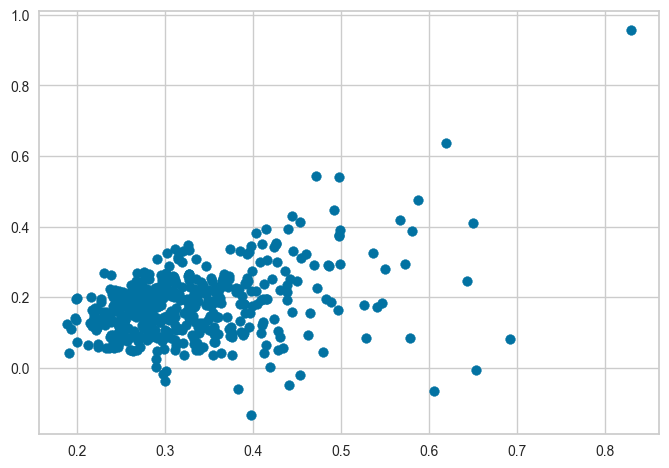

In [228]:
import matplotlib.pyplot as plt
plt.scatter(stock_data["Yavg_volatility"], stock_data["Yavg_return"])
# plt.ylim((-0.2,0.6))
# plt.xlim((0,1))
plt.show()

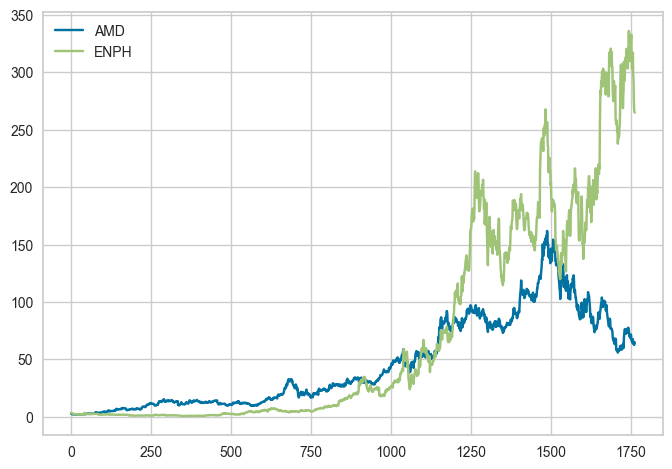

In [234]:
outliers = stock_data[
    (stock_data["Yavg_volatility"] > 0.6) & (stock_data["Yavg_return"] > 0.6)]["Ticker"].unique()
i = 0
ds = data_vertical(dataset)
# plt.subplot(2,1,1)
for asset in outliers:
  if asset != "ADTX":
    prices = np.array(ds[ds["Ticker"] == asset]["Close"])
    plt.plot(prices, label = asset, color = f"C{i}")
    plt.legend()
    i += 1
# plt.subplot(2,1,2)
# prices = np.array(ds[ds["Ticker"] == "ADTX"]["Close"])
# plt.plot(prices, label="ADTX", color = f"C{i}")
# plt.legend()
# plt.show()

In [187]:
stock_data = stock_data[~stock_data["Ticker"].isin(outliers)].dropna()

In [188]:
stock_data.describe()

,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,totalEsg,environmentScore,socialScore,governanceScore
count,474.000000,474.000000,474.000000,4.740000e+02,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,0.175127,0.325116,2.737142,6.330698e+06,-0.058933,-0.000628,-0.000997,14.271050,20.482848,5.836624,9.060211,5.586013
std,0.090779,0.083945,5.175033,2.533498e+07,0.876040,0.000658,0.001047,20.039629,6.651513,5.051264,3.601461,2.292507
min,-0.133953,0.188405,0.109287,2.632401e+04,-2.193859,-0.005488,-0.007937,2.687634,6.310000,0.000000,0.820000,2.010000
25%,0.117417,0.267419,1.008483,1.218158e+06,-0.372270,-0.000750,-0.001197,7.788865,15.217500,1.820000,6.702500,4.012500
50%,0.173055,0.304728,1.744016,2.361051e+06,-0.078597,-0.000398,-0.000630,11.108925,20.065000,4.230000,8.850000,4.975000
75%,0.220657,0.364336,2.998764,5.106716e+06,0.179955,-0.000210,-0.000332,15.730712,24.770000,8.995000,11.467500,6.570000
max,0.637559,0.691800,92.843006,5.022319e+08,13.902236,-0.000010,-0.000016,401.397548,43.660000,27.690000,22.180000,18.200000


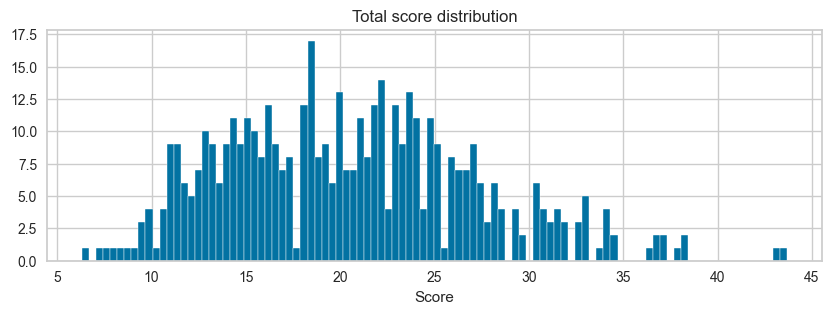

In [189]:
plt.figure(figsize=(10,3))
# stock_data["totalEsg"].value_counts().plot(kind="hist", bins=10)
plt.hist(stock_data["totalEsg"], bins=100)
plt.title("Total score distribution")
plt.xlabel("Score")
plt.show()

In [190]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 474 entries, 0 to 478
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ticker            474 non-null    object 
 1   Yavg_return       474 non-null    float64
 2   Yavg_volatility   474 non-null    float64
 3   Davg_span         474 non-null    float64
 4   Davg_volume       474 non-null    float64
 5   D_eSkewness       474 non-null    float64
 6   D_eVaR            474 non-null    float64
 7   D_eCVaR           474 non-null    float64
 8   D_eCurtosis       474 non-null    float64
 9   totalEsg          474 non-null    float64
 10  environmentScore  474 non-null    float64
 11  socialScore       474 non-null    float64
 12  governanceScore   474 non-null    float64
dtypes: float64(12), object(1)
memory usage: 51.8+ KB


In [191]:
stock_data_clustering = stock_data.copy()
# for type, feature in zip(stock_data.dtypes, stock_data.columns):
#     if type == "object" and feature!="Ticker":
#         stock_data_clustering[feature] = stock_data[feature].astype('category').cat.codes
# stock_data = stock_data.dropna()
stock_data_clustering = stock_data_clustering.drop(columns=["Ticker"])
stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 474 entries, 0 to 478
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Yavg_return       474 non-null    float64
 1   Yavg_volatility   474 non-null    float64
 2   Davg_span         474 non-null    float64
 3   Davg_volume       474 non-null    float64
 4   D_eSkewness       474 non-null    float64
 5   D_eVaR            474 non-null    float64
 6   D_eCVaR           474 non-null    float64
 7   D_eCurtosis       474 non-null    float64
 8   totalEsg          474 non-null    float64
 9   environmentScore  474 non-null    float64
 10  socialScore       474 non-null    float64
 11  governanceScore   474 non-null    float64
dtypes: float64(12)
memory usage: 48.1 KB


In [192]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
# numerical_features = stock_data_clustering.select_dtypes(include=["float64", "int64"]).columns
# categorical_features = stock_data_clustering.select_dtypes(include=["int8"]).columns
# scaler = StandardScaler()
# scaled_numerical = pd.DataFrame(scaler.fit_transform(stock_data_clustering[numerical_features]), columns=numerical_features)

# # Combine scaled numerical features with categorical features
# stock_data_clustering = pd.concat([scaled_numerical, stock_data_clustering[categorical_features].reset_index(drop=True)], axis=1)
# stock_data_clustering.info()
scaler = StandardScaler()
stock_data_clustering = pd.DataFrame(scaler.fit_transform(stock_data_clustering), columns=stock_data_clustering.columns)
# stock_data_clustering = stock_data_clustering.fillna(-1)
stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Yavg_return       474 non-null    float64
 1   Yavg_volatility   474 non-null    float64
 2   Davg_span         474 non-null    float64
 3   Davg_volume       474 non-null    float64
 4   D_eSkewness       474 non-null    float64
 5   D_eVaR            474 non-null    float64
 6   D_eCVaR           474 non-null    float64
 7   D_eCurtosis       474 non-null    float64
 8   totalEsg          474 non-null    float64
 9   environmentScore  474 non-null    float64
 10  socialScore       474 non-null    float64
 11  governanceScore   474 non-null    float64
dtypes: float64(12)
memory usage: 44.6 KB


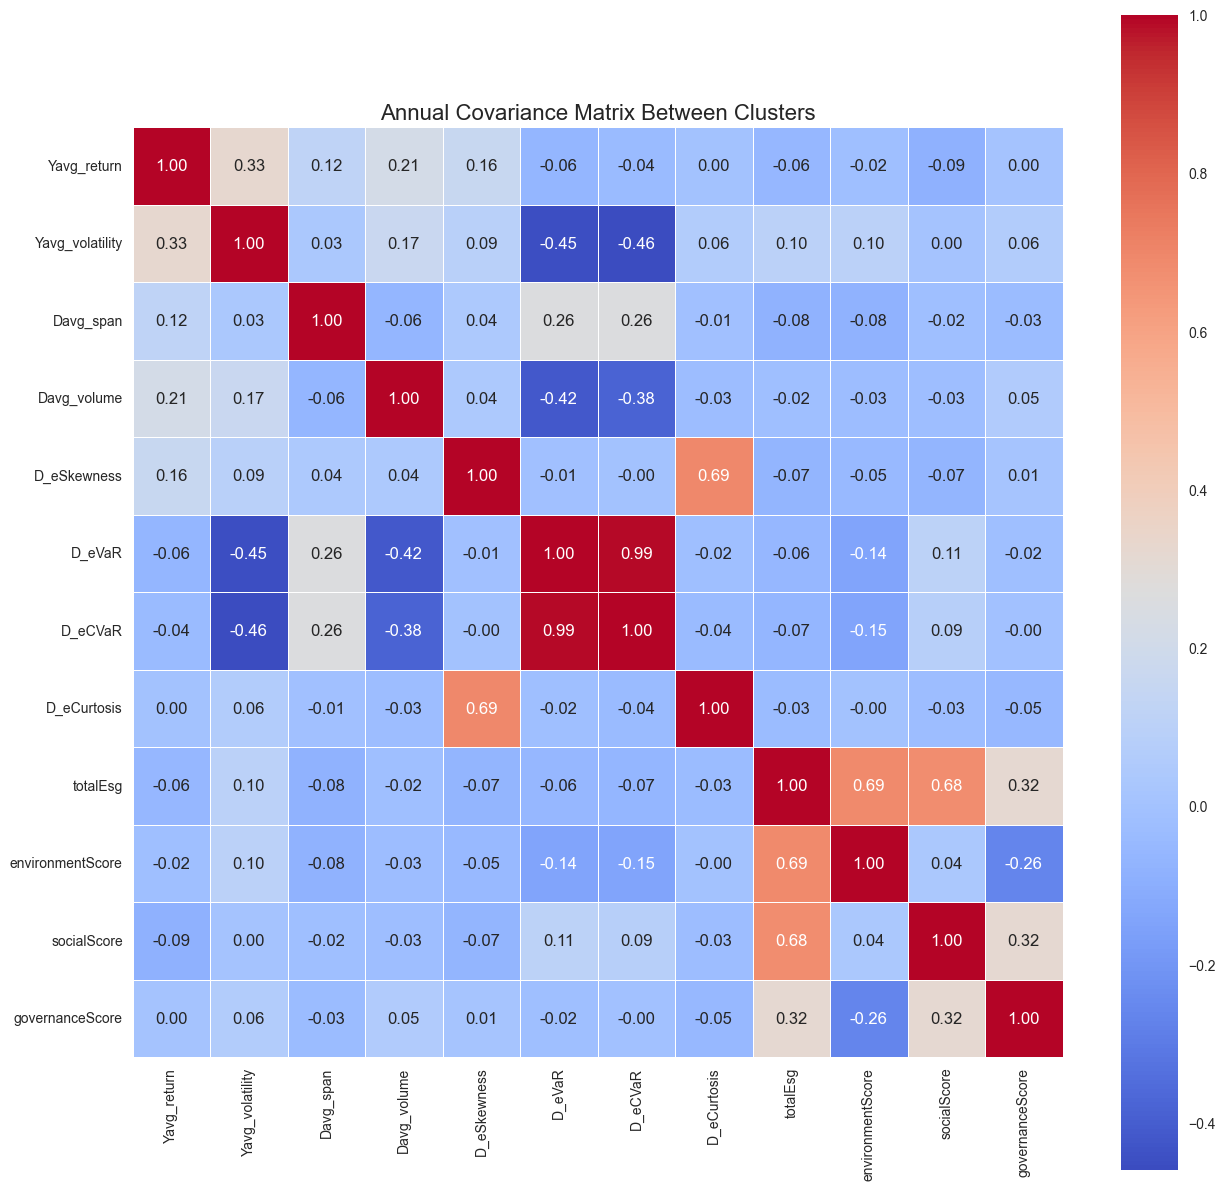

In [193]:
import seaborn as sns
correlation = stock_data_clustering.corr()
plt.figure(figsize=(15, 15))  
sns.heatmap(
    correlation, 
    annot=True,  # Annotate the heatmap with the covariance values
    fmt=".2f",   # Format for the numbers
    cmap="coolwarm",  # Colormap for the heatmap
    linewidths=0.5,   # Add grid lines
    square=True       # Make the heatmap square
)

# 3. Add a title
plt.title("Annual Covariance Matrix Between Clusters", fontsize=16)
plt.show()

In [194]:
useless = ["D_eVaR"]
stock_data_clustering = stock_data_clustering.drop(columns=useless)

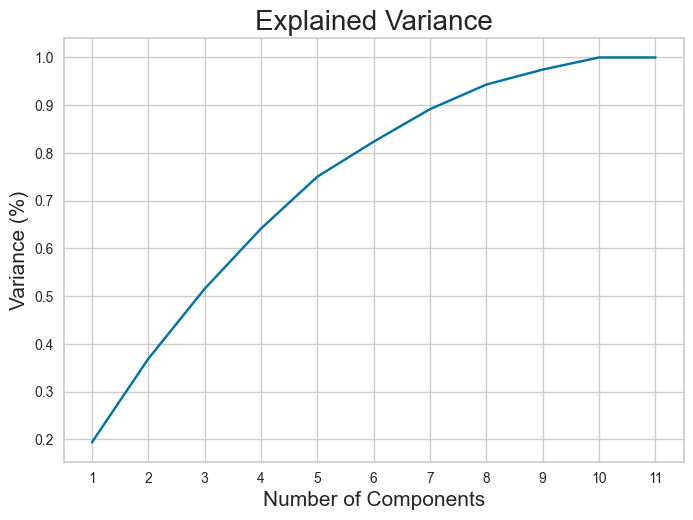

In [195]:
from sklearn.decomposition import PCA

# pass through the scaled data set into our PCA class object
pca = PCA().fit(stock_data_clustering)

# plot the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.arange(1,12), np.cumsum(pca.explained_variance_ratio_))

# define the labels & title
plt.xlabel('Number of Components', fontsize = 15)
plt.ylabel('Variance (%)', fontsize = 15) 
plt.title('Explained Variance', fontsize = 20)
plt.xticks(np.arange(1,12))
# show the plot
plt.show()

In [196]:
n= 11
pca_dataset = PCA(n_components=n).fit(stock_data_clustering).transform(stock_data_clustering)

# store it in a new data frame
pca_dataset= pd.DataFrame(data = pca_dataset, columns = [f'principal component {i+1}' for i in range(n)])
pca_dataset

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11
0,-1.917985,-0.569517,-0.692816,0.057795,0.093290,0.248122,-0.753094,0.316863,-0.168465,0.093227,0.001032
1,-0.548357,1.620774,-1.513303,2.592487,-0.440206,3.406128,-0.013137,-0.729900,1.247217,-0.371995,0.000161
2,1.424555,-0.913923,0.413088,1.873594,-0.231344,0.436160,-0.595469,0.547656,-0.533555,-0.476709,0.000019
3,0.523786,-1.059209,0.283300,1.070809,-0.396648,0.574420,-0.381045,0.713049,-0.362453,0.154055,0.000004
4,0.184039,-0.254644,-0.037664,1.286775,-0.909902,-0.251307,-0.294316,-0.434223,-0.665279,-0.244658,0.000011
...,...,...,...,...,...,...,...,...,...,...,...
469,0.264289,-0.303609,-0.085202,-0.967194,0.510168,0.434212,-0.674365,-0.258702,-0.077849,0.176900,-0.000044
470,-0.655694,0.339444,2.093964,-0.973014,-0.238402,0.922981,-0.340015,0.548350,-0.178355,0.723360,0.000010
471,1.242654,-1.035603,0.954824,0.681664,-0.536875,0.089276,0.358098,0.255330,0.284623,0.444102,-0.000004
472,-2.357765,0.376939,-0.696377,0.435966,1.267904,-0.634955,-0.429860,-0.316998,0.517251,-0.038491,-0.000012


In [197]:


#---------------------------------------------------------------------
# to compute distances for the centroid methodology (KMeans)
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#----------------------------------------------------------------------
# to compute distances for the hierarchical clustering
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet



#----------------------------------------------------------------------
# good practice
%matplotlib inline

# to remove warnings
import warnings
warnings.filterwarnings('ignore')

In [198]:
clusters = range(2, 20)
meanDistortions = []
sil_score = []
inertias = []
runs = 60
for i in range(runs):
    run_sil = []
    run_dist = []
    run_in = []
    for k in clusters:
        model = KMeans(n_clusters=k, random_state=i)
        model.fit(pca_dataset)
        prediction = model.predict(pca_dataset)
        score = silhouette_score(pca_dataset, prediction)
        distortion = (
            sum(
                np.min(cdist(pca_dataset, model.cluster_centers_, "euclidean"), axis=1)
            )
            / pca_dataset.shape[0]
        )
        run_in.append(model.inertia_)
        run_dist.append(distortion)
        run_sil.append(score)
    sil_score.append(run_sil)
    meanDistortions.append(run_dist)
    inertias.append(run_in)
        # print("\nNumber of Clusters:", k, "\tAverage Distortion:", distortion)
        # print("For n_clusters = {}, silhouette score is {}".format(k, score))

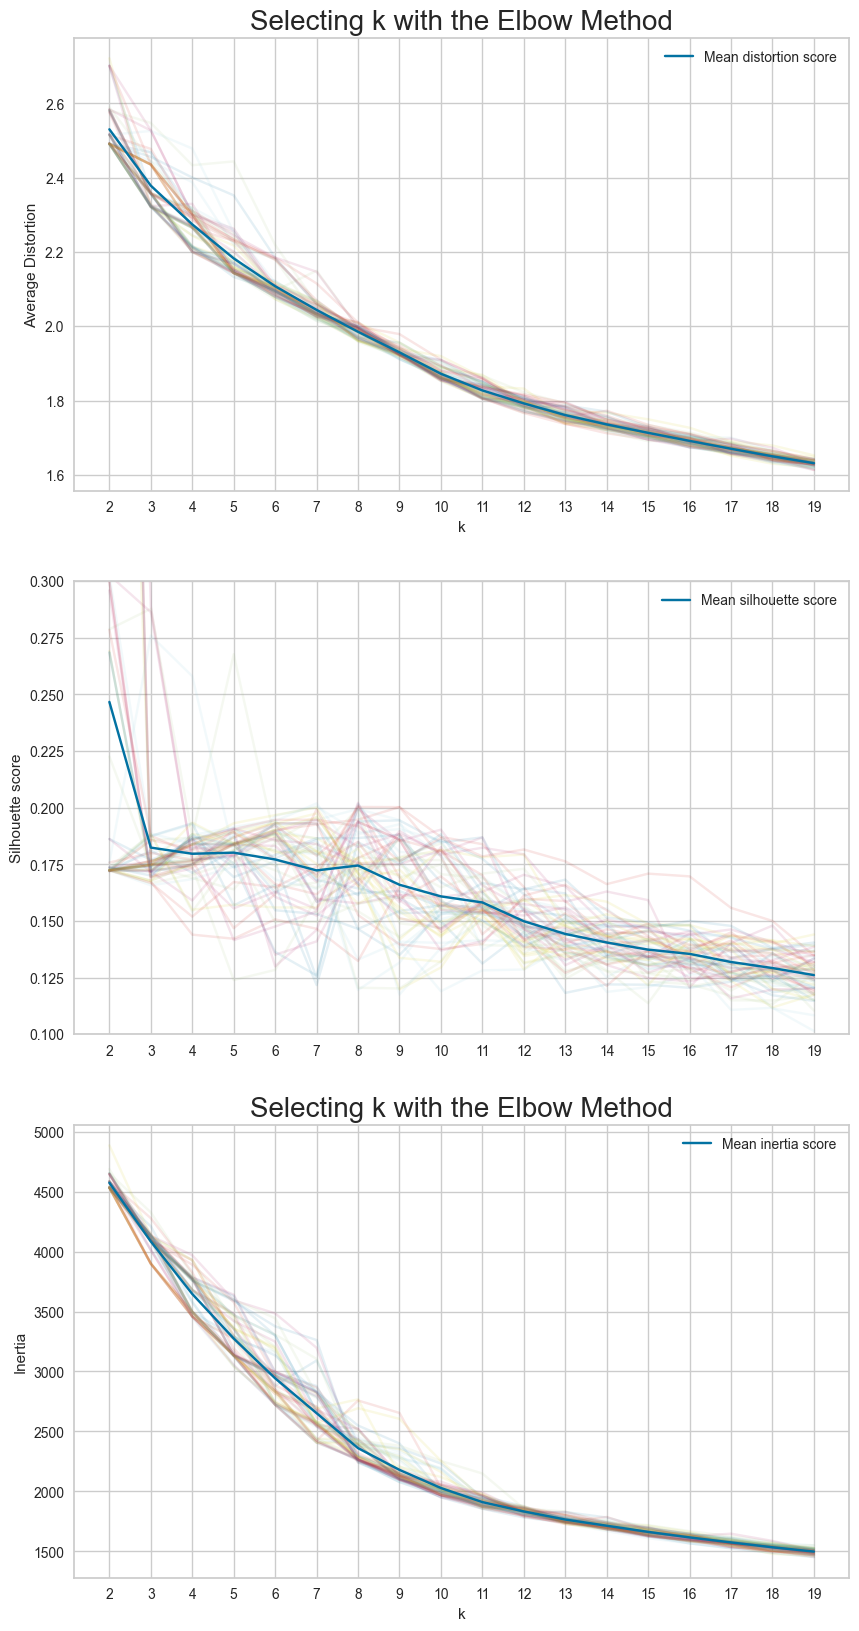

In [200]:
plt.figure(figsize=(10,20))
plt.subplot(3,1,1)
for i in range(runs): 
    plt.plot(clusters, meanDistortions[i], color=f"C{i}", alpha = 0.1)
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.xticks(clusters)
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.plot(clusters, np.mean(np.array(meanDistortions), axis=0), label="Mean distortion score")
plt.legend()
plt.subplot(3,1,2)
for i in range(runs): 
    plt.plot(clusters, sil_score[i], color=f"C{i}", alpha = 0.1)
plt.ylabel("Silhouette score")
plt.ylim(0.1, 0.3)
plt.xticks(clusters)
plt.plot(clusters, np.mean(np.array(sil_score), axis=0), label="Mean silhouette score")
plt.legend()
plt.subplot(3,1,3)
for i in range(runs): 
    plt.plot(clusters, inertias[i], color=f"C{i}", alpha = 0.1)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks(clusters)
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.plot(clusters, np.mean(np.array(inertias), axis=0), label="Mean inertia score")
plt.legend()
plt.show()

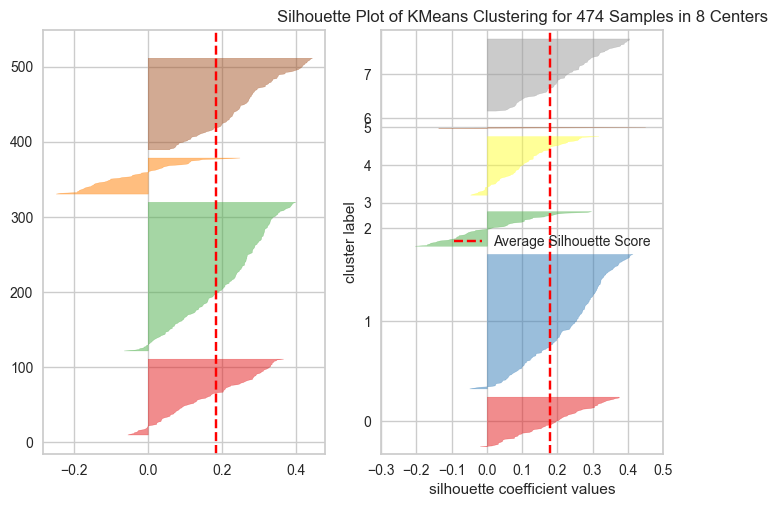

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 474 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [201]:
plt.subplot(1,2,1)
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(stock_data_clustering)
plt.subplot(1,2,2)
visualizer = SilhouetteVisualizer(KMeans(8, random_state=1))

visualizer.fit(stock_data_clustering)

visualizer.show()

In [206]:
N_SECTORS = 5

kmeans = KMeans(n_clusters=N_SECTORS, random_state=0)
kmeans.fit(stock_data_clustering)
stock_data["K_means_segments"] = kmeans.labels_
stock_data.head()


,Ticker,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,totalEsg,environmentScore,socialScore,governanceScore,K_means_segments
0,A,0.231620,0.271466,1.761373,1.979893e+06,-0.248165,-0.000320,-0.000468,4.864287,11.36,1.19,6.23,3.93,4
1,AAPL,0.287298,0.303828,1.752841,1.209567e+08,-0.024157,-0.000394,-0.000586,5.374806,16.79,0.55,7.52,8.72,1
2,ABBV,0.228479,0.270974,1.647473,7.382030e+06,-0.655543,-0.000354,-0.000588,12.704431,26.10,1.78,15.70,8.62,1
3,ABT,0.184229,0.249524,1.414195,6.388588e+06,-0.241481,-0.000341,-0.000534,6.772872,22.21,1.81,13.84,6.56,1
4,ACGL,0.185249,0.286301,0.683120,1.675522e+06,-0.311839,-0.000880,-0.001469,14.864780,20.27,1.57,9.92,8.78,1


In [207]:
cluster_profile = stock_data.groupby("K_means_segments").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = stock_data.groupby("K_means_segments")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]
cluster_profile.style.highlight_max(color="green", axis=0)

,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,totalEsg,environmentScore,socialScore,governanceScore,Count,Sharpe_ratio
K_means_segments,,,,,,,,,,,,,,
0,0.243683,0.473334,1.221761,13229068.958147,-0.001901,-0.001725,-0.002769,16.092647,25.734255,11.836170,8.779574,5.119149,47,0.472568
1,0.158677,0.316135,2.235139,6822092.054767,-0.119109,-0.000578,-0.000918,13.326398,22.214808,1.856250,11.716827,8.642596,104,0.438664
2,0.540813,0.497500,0.352270,502231876.844495,0.386831,-0.005488,-0.007937,7.959181,12.230000,2.730000,3.860000,5.650000,1,1.046859
3,0.144859,0.279924,1.983585,4334345.755419,-0.053109,-0.000447,-0.000716,14.117363,26.389677,10.477661,10.984839,4.926694,124,0.446047
4,0.184602,0.322082,3.844502,3180788.825224,-0.046763,-0.000482,-0.000760,14.462958,14.669040,3.612374,6.552374,4.503939,198,0.511058


----------------------------------------------------------------------------------------------------


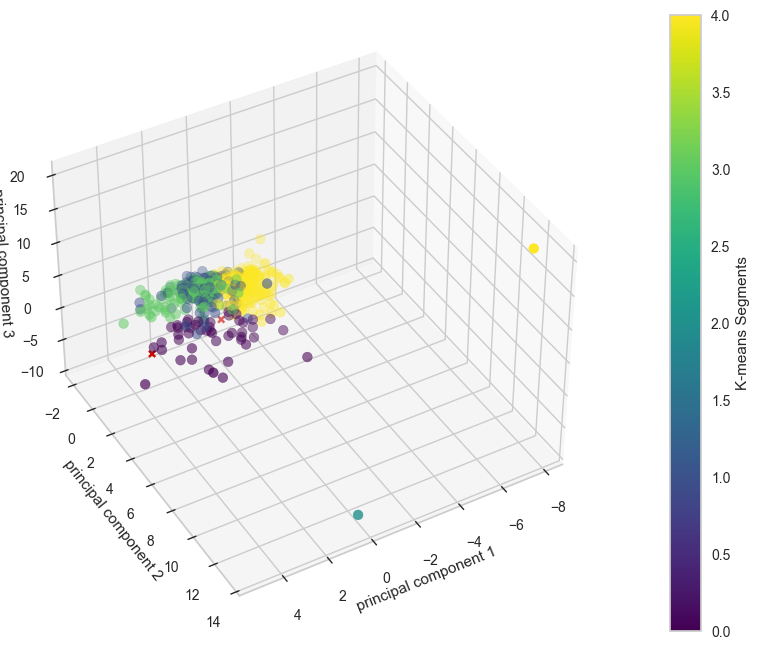

----------------------------------------------------------------------------------------------------


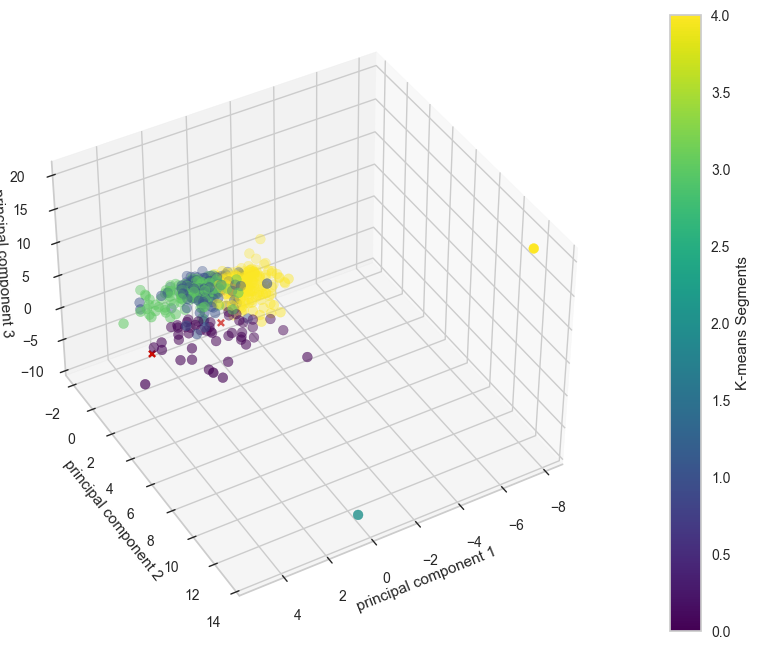

In [208]:
# plt.scatter(
#     stock_data["Yavg_volatility"], 
#     stock_data["Yavg_return"], 
#     c=stock_data["K_means_segments"],  # Use c for color mapping
#     cmap='viridis'  # Optional: Choose a colormap
# )

# # Add labels and title
# plt.xlabel("Yavg Volatility")
# plt.ylabel("Yavg Return")
# plt.title("Scatter plot of Yavg Return vs Yavg Volatility")

# # Show the plot
# plt.colorbar(label="K-means Segments")  # Optional: Add a colorbar
# plt.show()
n = 3
pca_dataset = PCA(n_components=n).fit(stock_data_clustering).transform(stock_data_clustering)

# store it in a new data frame
pca_dataset= pd.DataFrame(data = pca_dataset, columns = [f'principal component {i+1}' for i in range(n)])

clusters = [4,5]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= cluster, random_state=0).fit(stock_data_clustering)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]



    

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot
    scatter = ax.scatter(
        pca_dataset['principal component 1'], 
        pca_dataset['principal component 2'], 
        pca_dataset['principal component 3'],  # Use the additional feature for the z-axis
        c=stock_data["K_means_segments"],  # Color by K-means segments
        cmap='viridis',  # Colormap
        s=50  # Adjust marker size,

    )
    ax.view_init(elev=40, azim=60)
    # Add labels and title
    column_names = pca_dataset.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])
    ax.set_title("")
    scatter2 = ax.scatter(C1, 
                          C2, 
                          C3,
                          marker="x", color='r')
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label("K-means Segments")

    # Show the plot
    plt.show()

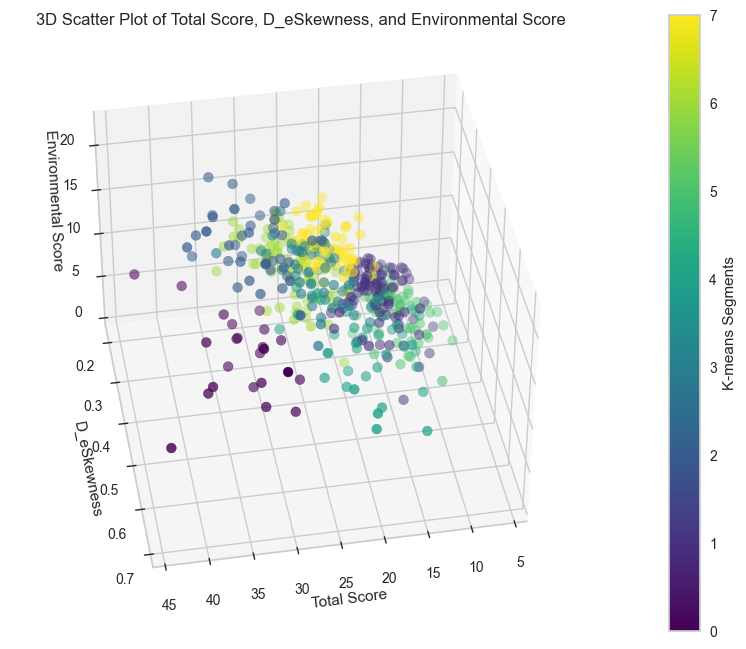

In [140]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    stock_data["totalEsg"], 
    stock_data["Yavg_volatility"], 
    stock_data["socialScore"],  # Use the additional feature for the z-axis
    c=stock_data["K_means_segments"],  # Color by K-means segments
    cmap='viridis',  # Colormap
    s=50  # Adjust marker size,

)
ax.view_init(elev=40, azim=80)
# Add labels and title
ax.set_xlabel("Total Score")
ax.set_ylabel("D_eSkewness")
ax.set_zlabel("Environmental Score")
ax.set_title("3D Scatter Plot of Total Score, D_eSkewness, and Environmental Score")

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("K-means Segments")

# Show the plot
plt.show()


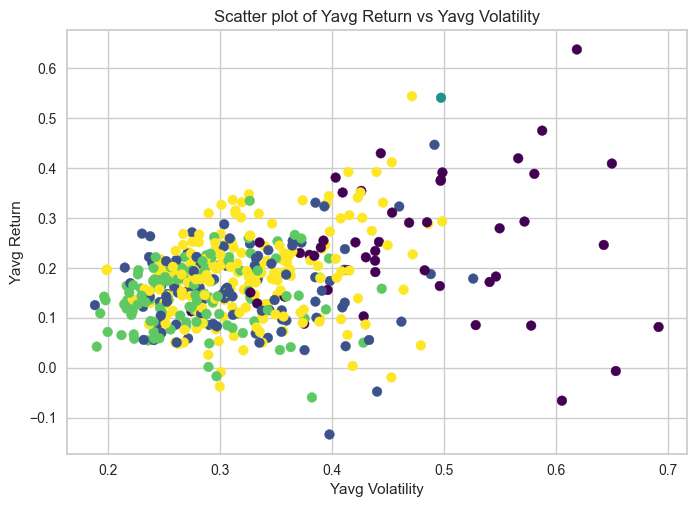

In [209]:
plt.scatter(
    stock_data["Yavg_volatility"], 
    stock_data["Yavg_return"], 
    c=stock_data["K_means_segments"],  # Use c for color mapping
    cmap='viridis'  # Optional: Choose a colormap
)

# Add labels and title
plt.xlabel("Yavg Volatility")
plt.ylabel("Yavg Return")
plt.title("Scatter plot of Yavg Return vs Yavg Volatility")

# Show the plot
plt.show()

In [246]:
sd = "2024-01-01"
ed = "2025-01-25"
portfolio_data= yf.download(tickers=list(stock_data["Ticker"]), start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  479 of 479 completed


In [211]:
portfolio_dataset = pd.DataFrame(portfolio_data)
missing_frac = portfolio_dataset.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.1].index))
portfolio_dataset.drop(columns=drop_list, axis = 1, inplace=True)
portfolio_dataset.ffill(axis='index', inplace=True)
print('Null values:', portfolio_dataset.isnull().values.any())

Null values: False


In [212]:
# pd.merge(portfolio_dataset, final_dataframe, on="Ticker")


# Example K_means_segments DataFrame
ticker_segments = pd.DataFrame({
    "Ticker": stock_data["Ticker"],
    "K_means_segments": stock_data["K_means_segments"],
})

# 1. Reshape daily_prices to long format
portfolio_dataset_long = portfolio_dataset.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Close")

# 2. Merge with ticker_segments to get segment information
merged_data = pd.merge(portfolio_dataset_long, ticker_segments, on="Ticker")

# 3. Calculate daily returns for each ticker
merged_data["Daily_Return"] = merged_data.groupby("Ticker")["Close"].pct_change()
merged_data = merged_data.dropna()
# 4. Group by Date and K_means_segments to calculate equally weighted portfolio returns
portfolio_returns = (
    merged_data.groupby(["Date", "K_means_segments"])["Daily_Return"]
    .mean()  # Equally weighted
    .reset_index()
)

# 5. Pivot the data for better visualization (optional)
portfolio_returns = portfolio_returns.pivot(
    index="Date", columns="K_means_segments", values="Daily_Return"
).dropna()


# Print results
print("Merged Data:\n", merged_data)
print("\nPortfolio Returns:\n", portfolio_returns)

Merged Data:
              Date Ticker       Close  K_means_segments  Daily_Return
1      2024-01-03      A  130.256210                 4     -0.054703
2      2024-01-04      A  130.097321                 4     -0.001220
3      2024-01-05      A  129.660324                 4     -0.003359
4      2024-01-08      A  132.460907                 4      0.021599
5      2024-01-09      A  129.779480                 4     -0.020243
...           ...    ...         ...               ...           ...
126553 2025-01-17    ZTS  165.389999                 4     -0.020547
126554 2025-01-21    ZTS  167.529999                 4      0.012939
126555 2025-01-22    ZTS  166.630005                 4     -0.005372
126556 2025-01-23    ZTS  166.960007                 4      0.001980
126557 2025-01-24    ZTS  168.610001                 4      0.009883

[126084 rows x 5 columns]

Portfolio Returns:
 K_means_segments         0         1         2         3         4
Date                                       

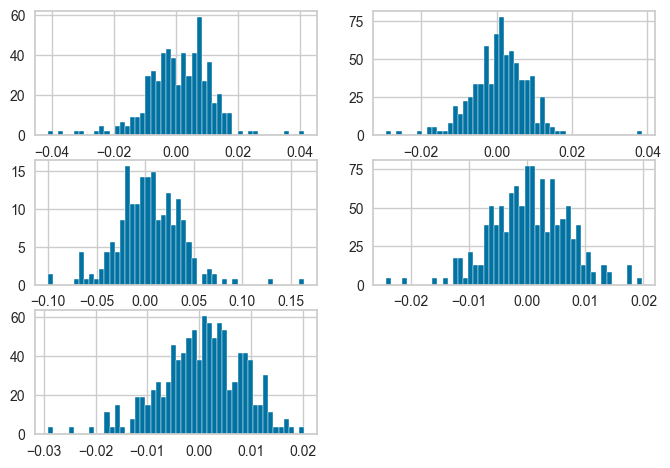

In [214]:
plots = len(portfolio_returns.columns)
for i in range(plots):
    plt.subplot(3,2,i+1)
    plt.hist(portfolio_returns[i], bins=50, density=True)
plt.show()


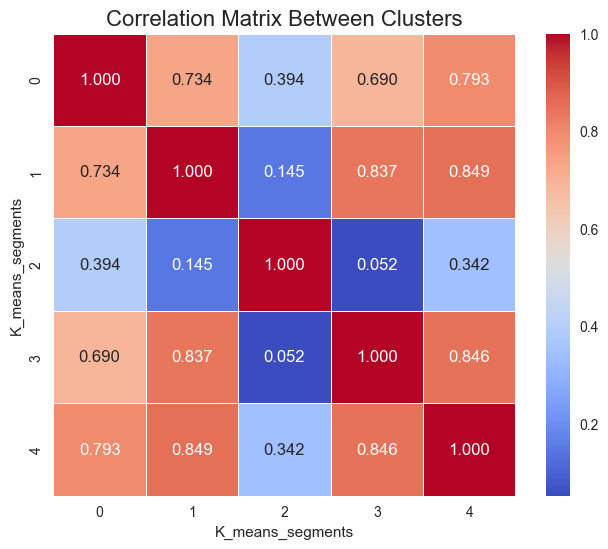

In [215]:
cor_matrix = portfolio_returns.corr()

# 2. Create a heatmap using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(
    cor_matrix, 
    annot=True,  # Annotate the heatmap with the covariance values
    fmt=".3f",   # Format for the numbers
    cmap="coolwarm",  # Colormap for the heatmap
    linewidths=0.5,   # Add grid lines
    square=True       # Make the heatmap square
)

# 3. Add a title
plt.title("Correlation Matrix Between Clusters", fontsize=16)
plt.show()

In [216]:
def weights(ratios, cluster, pow):
    ratios["weights"] = np.power(ratios["Sharpe_ratio"], pow)
    ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
    return ratios.loc[ratios["K_means_segments"] == cluster, "weights"]

In [217]:
import quantstats as qs

returns = np.zeros(len(portfolio_returns))
cp = cluster_profile.reset_index()
for i in portfolio_returns.columns:
        returns += weights(cp[["K_means_segments", "Sharpe_ratio"]], i, 1).values[0]*portfolio_returns[i] 
portfolio_performance = pd.DataFrame(returns).reset_index()
portfolio_performance

,Date,0
0,2024-01-03,-0.011893
1,2024-01-04,0.001790
2,2024-01-05,0.010316
3,2024-01-08,0.029366
4,2024-01-09,0.002451
...,...,...
261,2025-01-17,0.014474
262,2025-01-21,0.014790
263,2025-01-22,0.012244
264,2025-01-23,0.003146


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-01-04   2024-01-04
End Period                 2025-01-24   2025-01-24
Risk-Free Rate             2.0%         2.0%
Time in Market             100.0%       100.0%

Cumulative Return          31.35%       73.97%
CAGR﹪                     19.49%       43.55%

Sharpe                     1.96         2.39
Prob. Sharpe Ratio         96.24%       98.73%
Smart Sharpe               1.86         2.27
Sortino                    2.86         3.83
Smart Sortino              2.71         3.63
Sortino/√2                 2.02         2.71
Smart Sortino/√2           1.92         2.57
Omega                      1.49         1.49

Max Drawdown               -8.41%       -11.35%
Longest DD Days            64           51
Volatility (ann.)          12.63%       22.22%
R^2                        0.68         0.68
Information Ratio          0.13         0.13
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-07-17,2024-08-07,2024-08-16,31,-11.354104,-11.139930
2,2024-03-26,2024-04-19,2024-05-14,50,-9.560719,-7.681036
3,2024-08-26,2024-09-06,2024-09-25,31,-9.440685,-7.734515
4,2024-12-05,2024-12-18,2025-01-24,51,-8.133194,-7.952041
5,2024-06-20,2024-06-24,2024-07-09,20,-4.141554,-3.297869


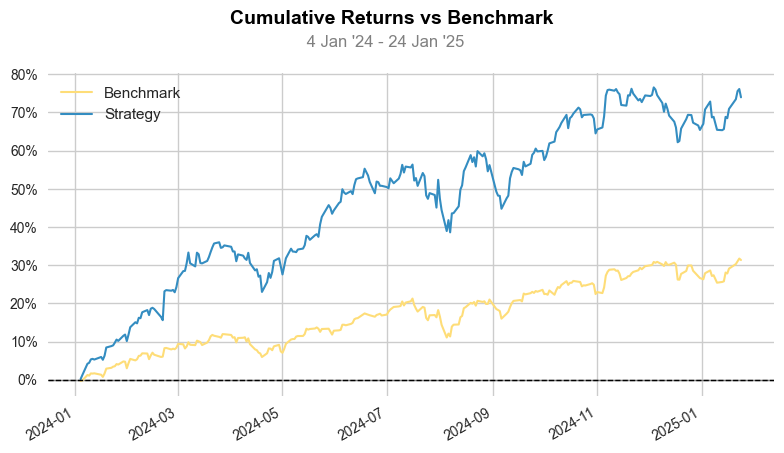

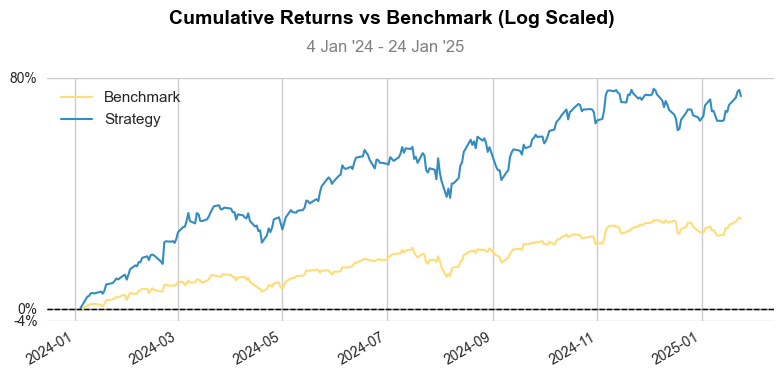

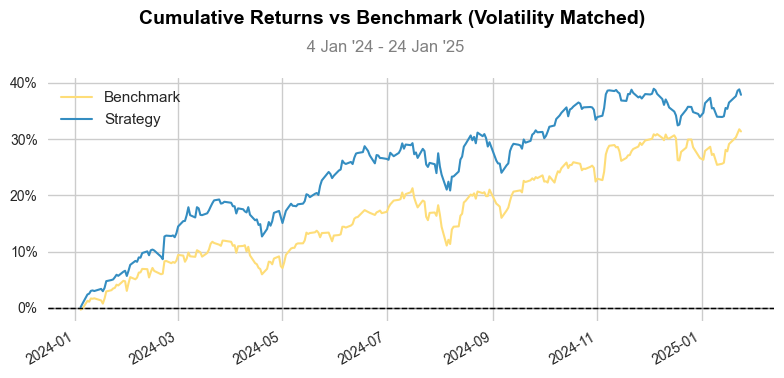

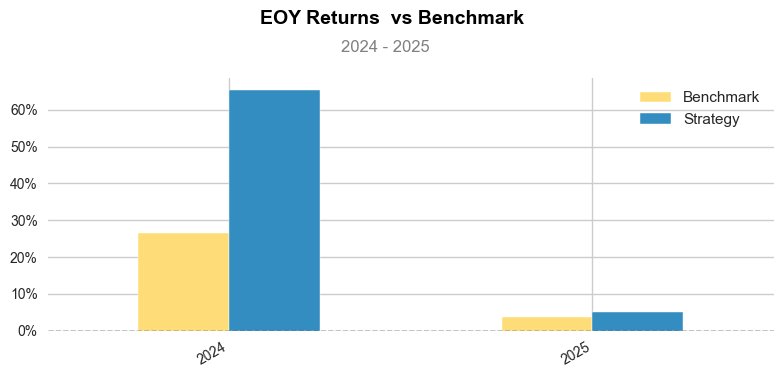

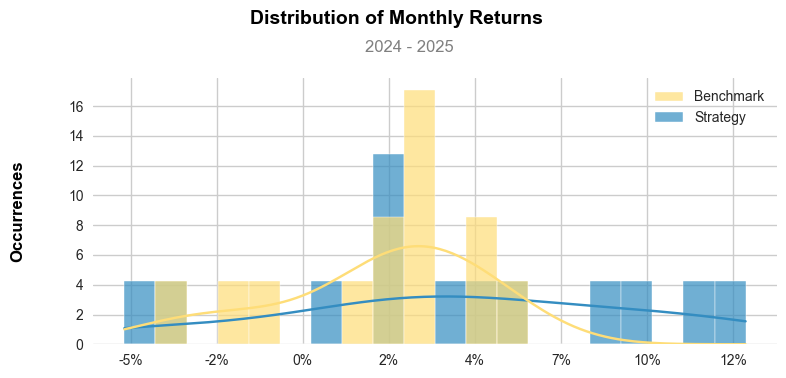

UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [218]:
portfolio_performance["Date"] = pd.to_datetime(portfolio_performance["Date"])

# Set "Date" as the index
portfolio_performance.set_index("Date", inplace=True)

# Rename the column for better clarity (optional)
portfolio_performance.columns = ["Returns"]

# Ensure the returns are properly formatted and call the quantstats report
qs.reports.full(portfolio_performance["Returns"], benchmark="SPY", rf=0.02)

In [ ]:
benchmark = yf.download(tickers="SPY", start=sd, end=ed, auto_adjust=True)["Close"]

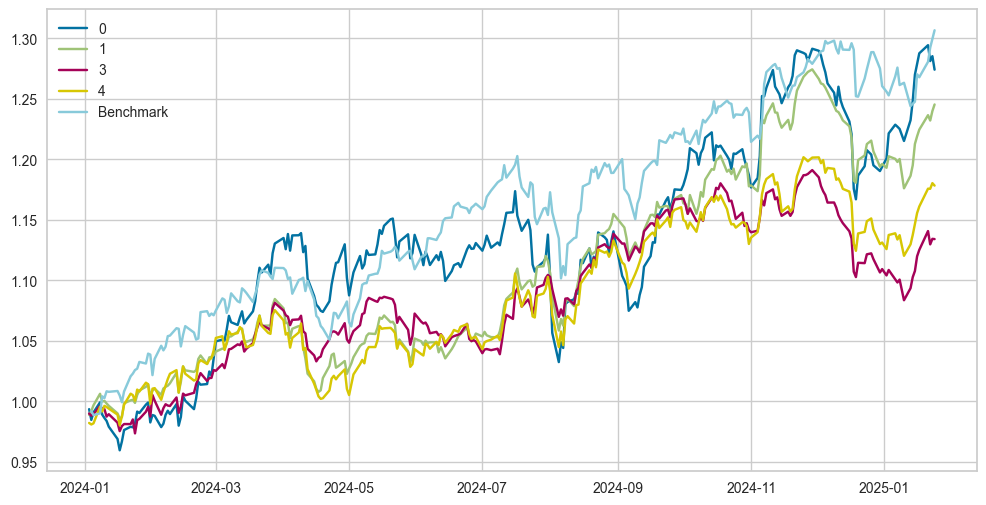

In [256]:
portfolio_evolution = pd.DataFrame(portfolio_returns.reset_index()["Date"])
plt.figure(figsize=(12, 6))
for portfolio in portfolio_returns.reset_index().columns:
    if portfolio != "Date" and portfolio != 2:
        portfolio_evolution[portfolio] = (1 + portfolio_returns.reset_index()[portfolio]).cumprod()
        plt.plot(portfolio_evolution["Date"], portfolio_evolution[portfolio], label = portfolio, color = f"C{portfolio}")
portfolio_evolution["SPY"] = (1 + benchmark.reset_index()["SPY"].pct_change()).cumprod()
plt.plot(portfolio_evolution["Date"], portfolio_evolution["SPY"], label = "Benchmark", color = f"C{portfolio+1}")
plt.legend()
plt.show()
# # Plot the time series

# plt.title("Portfolio Evolution Over Time", fontsize=16)
# plt.xlabel("Date", fontsize=14)
# plt.ylabel("Portfolio Value ($)", fontsize=14)
# plt.grid(True)
# plt.legend(fontsize=12)
# plt.show()